https://www.kaggle.com/code/papewalycisse/fine-tuning-roberta#Evaluate-the-model

In [3]:
%pip install  --upgrade "transformers==4.40.2"
%pip install datasets
%pip install keras
%pip install tensorflow
%pip install seaborn

   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.0 MB 10.1 MB/s eta 0:00:01
   --------------- ------------------------ 3.4/9.0 MB 11.2 MB/s eta 0:00:01
   -------------------------- ------------- 6.0/9.0 MB 11.2 MB/s eta 0:00:01
   ------------------------------------- -- 8.4/9.0 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 9.0/9.0 MB 11.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 11.4 MB/s eta 0:00:00

  Attempting uninstall: tokenizers

    Found existing installation: tokenizers 0.21.2

    Uninstalling tokenizers-0.21.2:

      Successfully uninstalled tokenizers-0.21.2

   ---------------------------------------- 0/2 [tokenizers]
   ---------------------------------------- 0/2 [tokenizers]
   ---------------------------------------- 0/2 [tokenizers]
   --------------------------------------

  You can safely remove it manually.


Note: you may need to restart the kernel to use updated packages.
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-win_amd64.whl.metadata (22 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --------------- ------------------------ 0.5/1.4 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   -------------------------------- ------- 2.4/2.9 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 11.2 MB/s eta 0:00:00
Using cached ml_dtypes-0.5.1-cp311-cp311-win_amd64.whl (209 kB)
Using cached rich-14.0.0-py3-none-any.whl (243 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import warnings

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

In [6]:
comments_data=pd.read_csv("data/reddit_comments_clean.csv")
comments_data.head()

,post_id,id,label,text,timestamp,ups
0,175au9w,k4efycz,neutral,Israel pulled out of Gaza in 2005 so the 2010 ...,2023-10-11 11:56:11,1411
1,175au9w,k4eg0gi,with palestine,The 1946 map should be completely red as the w...,2023-10-11 11:56:49,833
2,175au9w,k4ees0u,with palestine,To be fair. You should count 1947 as the first...,2023-10-11 11:43:13,457
3,175au9w,k4eke8z,with israel,No. Each map is depicting something different....,2023-10-11 12:41:04,217
4,175au9w,k4eipaq,with israel,"A history of Israel over the last 100 years, i...",2023-10-11 12:24:44,168


In [7]:
posts_data=pd.read_csv("data/posts.csv")
posts_data.head()

,class,id,num_comments,preview,subreddit,text,timestamp,title,upvote_ratio,upvotes,url
0,NaN,175au9w,682,https://external-preview.redd.it/35qaia1zr0YPI...,r/geopolitics,NaN,2023-10-11 11:31:27,Is this Palestine-Israel map history accurate?,0.77,1060,https://solidarnost.su/wp-content/uploads/2015...
1,NaN,1c7lqqt,1375,https://external-preview.redd.it/mKqHVAGaLWiUI...,r/news,NaN,2024-04-19 03:26:18,Israel missiles strike Iran - US officials inf...,0.94,11643,https://www.reuters.com/world/middle-east/isra...
2,NaN,1c3pjmi,1492,NaN,r/NoStupidQuestions,Aren't they Jewish? Don't they specifically NO...,2024-04-14 10:26:07,"Why do Christian nationalists support Israel, ...",0.77,6048,https://www.reddit.com/r/NoStupidQuestions/com...
3,NaN,175v330,456,NaN,r/geopolitics,Basically the question above. I understand the...,2023-10-12 02:44:41,Why is Israel so significant for the West ?,0.87,366,https://www.reddit.com/r/geopolitics/comments/...
4,palestisrael,1c3aiv5,5143,https://external-preview.redd.it/8bwtWtE4wx8uq...,r/worldnews,NaN,2024-04-13 19:53:25,Iran launched dozens of drones toward Israel -...,0.91,28884,https://www.jpost.com/breaking-news/article-79...


In [8]:
posts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   class         726 non-null    object 
 1   id            2802 non-null   object 
 2   num_comments  2802 non-null   int64  
 3   preview       2307 non-null   object 
 4   subreddit     2802 non-null   object 
 5   text          551 non-null    object 
 6   timestamp     2802 non-null   object 
 7   title         2802 non-null   object 
 8   upvote_ratio  2802 non-null   float64
 9   upvotes       2802 non-null   int64  
 10  url           2802 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 240.9+ KB


we will train the model on two data:

* Data that includes information about the post title, post text, and comments.
* Data that includes only the comments.

In [9]:
merged_data=pd.merge(comments_data,posts_data,left_on='post_id', right_on='id', how='inner')
sentences=[]
for index,row in merged_data.iterrows():  
    if pd.notnull(row["text_y"]): 
        sentences.append("title of the post: "+row["title"]+"\n"+" post: "+row["text_y"]+"\n"+" comment: "+row["text_x"])
    else:
        sentences.append("title of the post: "+row["title"]+"\n"+" comment: "+row["text_x"])

In [10]:
dataset=merged_data
dataset["sentence"]=sentences
dataset=dataset[["sentence","label"]]
dataset.loc[:, "label"] = dataset["label"].apply(lambda x : "neutral" if x == "indifferent" or x == "inquisitive" else x)
dataset.loc[:,"len_sentence"]=dataset["sentence"].apply(lambda x: len(x.strip()))
dataset.head(5)

,sentence,label,len_sentence
0,title of the post: Is this Palestine-Israel ma...,neutral,598
1,title of the post: Is this Palestine-Israel ma...,with palestine,263
2,title of the post: Is this Palestine-Israel ma...,with palestine,301
3,title of the post: Is this Palestine-Israel ma...,with israel,823
4,title of the post: Is this Palestine-Israel ma...,with israel,4039


In [11]:
dataset1=merged_data[["label"]]
dataset1["sentence"]=merged_data["text_x"]
dataset1.loc[:, "label"] = dataset1["label"].apply(lambda x : "neutral" if x == "indifferent" or x == "inquisitive" else x)
dataset.loc[:,"len_sentence"]=dataset["sentence"].apply(lambda x: len(x.strip()))
dataset1.head(10)

,label,sentence
0,neutral,Israel pulled out of Gaza in 2005 so the 2010 ...
1,with palestine,The 1946 map should be completely red as the w...
2,with palestine,To be fair. You should count 1947 as the first...
3,with israel,No. Each map is depicting something different....
4,with israel,"A history of Israel over the last 100 years, i..."
5,with israel,Completely inaccurate. The first map removes t...
6,neutral,I would say “misleading at best”. The maps app...
7,with israel,I like the part where it pretends the 1967 map...
8,with israel,"1st is completely made up, there is no reason ..."
9,neutral,A simple no is the best answer the first map s...


In [12]:
labels=dataset['label'].unique()
id2label={ key:values for key,values in enumerate(labels)}
label2id={values:key for key,values in enumerate(labels)}
dataset.loc[:,"encoded_label"]=dataset["label"].map(label2id)
dataset1.loc[:,"encoded_label"]=dataset1["label"].map(label2id)

# the distribution of the length of sentences

we have plot the distribution of each sentences in our dataset so we can decide if the input_embeddings_maxlen is suitable for training our model on the data that we have.

in our case we can see that the length of the majority sentences in our dataset are between 0 and 600 so we will let the value of our input_embeddings_maxlen to its default values which is 512.

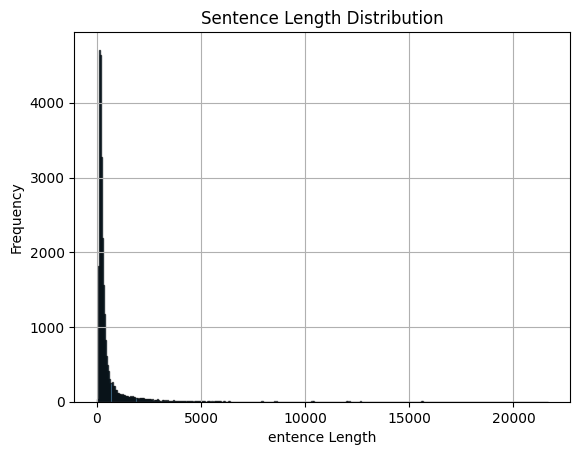

In [14]:
bins = range(0, max(dataset['len_sentence']) + 50, 50)
plt.hist(dataset['len_sentence'], bins=bins, edgecolor='black', alpha=0.7)
plt.title('Sentence Length Distribution')
plt.xlabel('entence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
print(dataset["label"].value_counts())

label
with palestine    9130
with israel       9052
neutral           8136
Name: count, dtype: int64


we can see that our data is well balanced

Encoding the label

In [16]:
print(dataset['label'].unique())

dataset.head()

['neutral' 'with palestine' 'with israel']


,sentence,label,len_sentence,encoded_label
0,title of the post: Is this Palestine-Israel ma...,neutral,598,0
1,title of the post: Is this Palestine-Israel ma...,with palestine,263,1
2,title of the post: Is this Palestine-Israel ma...,with palestine,301,1
3,title of the post: Is this Palestine-Israel ma...,with israel,823,2
4,title of the post: Is this Palestine-Israel ma...,with israel,4039,2


In [17]:
from transformers import RobertaTokenizer
tokenizer=RobertaTokenizer.from_pretrained("roberta-base")
tokenized_text=tokenizer(dataset.sentence.to_list(), padding="max_length", truncation=True, max_length=512)
tokenized_text_comments_only=tokenizer(dataset1.sentence.to_list(), padding="max_length", truncation=True, max_length=512)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [18]:
encoded_label=dataset.loc[:,"encoded_label"].tolist()

In [19]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,RandomSampler,DataLoader,SequentialSampler
def split_data(tokenized_data):
    
    train_inputs, test_inputs, train_labels, test_labels=train_test_split(tokenized_text["input_ids"],encoded_label, random_state=42, test_size=0.2)
    validation_inputs,test_inputs,validation_labels,test_labels=train_test_split(test_inputs,test_labels,random_state=42, test_size=0.5)
    train_masks, test_masks = train_test_split(tokenized_text["attention_mask"],random_state=42, test_size=0.2)
    validation_masks,test_masks=train_test_split(test_masks,random_state=42, test_size=0.5)

    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)
    test_inputs=torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)
    test_labels=torch.tensor(test_labels)
    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)
    test_masks=torch.tensor(test_masks)
    
    batch_size=32
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return (train_dataloader,train_inputs.shape[0]),(validation_dataloader,validation_inputs.shape[0]),(test_dataloader,test_inputs.shape[0])

In [20]:
train,validation,test=split_data(tokenized_text)
train1,validation1,test1=split_data(tokenized_text_comments_only)

In [21]:
from transformers import AutoModelForSequenceClassification,AutoConfig
model=AutoModelForSequenceClassification.from_pretrained("roberta-base",
                                  num_labels=3, 
                                  problem_type="multi_label_classification",
                                  id2label=id2label,
                                  label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(model.parameters)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<bound method Module.parameters of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_fea

In [22]:
# we add weight_decay to avoid overfitting
# we add it to all the other layers except for the bias and LayerNorm
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
 {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
 'weight_decay_rate': 0.001},

 {'params': [p for n, p in param_optimizer if any(nd in n for nd in
no_decay)],
 'weight_decay_rate': 0.0}
]

In [23]:
from torch.nn.parallel import DataParallel
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm, trange
import os

def train_evaluate(model,model_name,train_data,validation_data):
    
    output_dir = '/kaggle/working/models/'

    os.makedirs(output_dir, exist_ok=True)

    loss_set={"train_loss":[],"valid_loss":[]}
    
    model.to(device)
    model = DataParallel(model)
    
    # we defined the number of epoch for the training

    epochs = 4

    training_steps=len(train_data[0]) * epochs
    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=training_steps)
    # we used the crossEntropyLoss function because we are doing multiclassification
    loss_fn = nn.CrossEntropyLoss().to(device)

    best_model_accuracy=0

    for _ in trange(epochs, desc="Epoch"): 
            model.train()
            train_loss= []
            correct_predictions=0   
            for step, batch in enumerate(train_data[0]):
                    batch = tuple(t.to(device) for t in batch)
                    input_ids, input_mask, labels = batch
                    outputs = model(input_ids, attention_mask=input_mask)
                    logits=outputs.logits
                    _, preds = torch.max(logits, dim=1)
                    loss=loss_fn(logits,labels)
                    correct_predictions += torch.sum(preds == labels).cpu()
                    train_loss.append(loss.item())
                    loss.backward()
                    # to avoid gradiant exploding
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()  
            train_accuracy = correct_predictions / train_data[1]
            loss_set["train_loss"].append(train_loss)
            print(f"train_loss: {np.mean(train_loss)}")
            print(f"train_accuracy : {train_accuracy}")
   
            model.eval()
            valid_losses = []
            correct_predictions_valid = 0
            validation_accuracy=0

            for step,batch in enumerate(validation_data[0]):
                batch = tuple(t.to(device) for t in batch)
                valid_input, valid_mask, labels = batch

                with torch.no_grad():
                        outputs = model(valid_input, attention_mask=valid_mask)
                        _,preds = torch.max(outputs.logits, dim=1)
                        valid_loss = loss_fn(outputs.logits, labels)
                        correct_predictions_valid += torch.sum(preds == labels).cpu()
                        valid_losses.append(valid_loss.item())

            loss_set["valid_loss"].append(np.mean(valid_losses))
            validation_accuracy = correct_predictions_valid / validation_data[1]
            print(f"valid_loss: {np.mean(valid_losses)}")
            print(f"validation_accuracy: {validation_accuracy}")
            if validation_accuracy > best_model_accuracy:
                    best_model_accuracy = validation_accuracy
                    torch.save(model.module.state_dict(), os.path.join(output_dir, f'{model_name}.bin'))
                    
    return loss_set

In [25]:
loss_set=train_evaluate(model,"fine_tuned_roberta",train,validation)
print("------------------------------fine-tuned-only-on-the-comments--------------------------")
loss_set_comment_only=train_evaluate(model,"fine_tuned_roberta_comments",train1,validation1)

Epoch:   0%|          | 0/4 [05:53<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 22.16 GiB is allocated by PyTorch, and 69.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_on_testset(model_name): 
    model =  AutoModelForSequenceClassification.from_pretrained('roberta-base',
                                                      problem_type="multi_label_classification", 
                                                      num_labels=3,
                                                      id2label=id2label,
                                                      label2id=label2id
                                                     )

    state_dict = torch.load(f"/kaggle/working/models/{model_name}.bin")
    model.load_state_dict(state_dict)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds = []
    all_labels = []

    for batch in tqdm(test[0], desc="Evaluating on test data"):
        batch = tuple(t.to(device) for t in batch)
        test_input, test_mask, labels = batch

        with torch.no_grad():
                outputs = model(test_input, attention_mask=test_mask)
                logits = outputs.logits
                _, preds = torch.max(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(id2label))))
    print(cm)
    print(classification_report(all_labels,all_preds,target_names=list(id2label.values())))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(id2label.values()), yticklabels=list(id2label.values()))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
evaluate_on_testset("fine_tuned_roberta")
print("-----------------------------evaluation of the fine_tuned_roberta_comments model------------------------------------- ")
evaluate_on_testset("fine_tuned_roberta_comments")

In [ ]:
def get_predictions(title,post,commentaire,saved_model):
    from transformers import RobertaBertTokenizer,AutoModelForSequenceClassification
    import torch
    state_dict=torch.load(f"{saved_model}")
    tokenizer=RobertaBertTokenizer.from_pretrained("roberta-base-uncased")
    model =  AutoModelForSequenceClassification.from_pretrained('roberta-base',
                                                      problem_type="multi_label_classification", 
                                                      num_labels=3               
                                                     )
    model.load_state_dict(state_dict)
    device = torch.device("cpu")
    model.to(device)
    
    model.eval()
    inputs = tokenizer("title of the post: "+title+"\n"+"post: "+post+"\n"+"comment: "+commentaire, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
    id2label={
          0:"neutral",
          1:"with palestine",
          2:"with israel"
    }
    print(id2label)
    return id2label[preds.item()]